<a href="https://colab.research.google.com/github/dassus98/banking_churn/blob/main/Banking_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [ ]:
# Standard Library & Utilities
import pandas as pd
import numpy as np
import warnings
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML models & Sampling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_recall_curve
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration & Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', '{:.2f}'.format)

# Warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preparation

In [10]:
# Loading data
df = pd.read_csv('banking_churn.csv', header=0)

# Inspecting data
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

# Dropping irrelevant columns
drop_cols = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns = drop_cols)

# Defining features
X = df.drop(columns = ['Exited'])
y = df['Exited']

# Splitting features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    random_state = RANDOM_SEED, 
    stratify = y
    )

Shape: (10000, 14)
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


# Feature Engineering

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

# Defining custom transformer for feature engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Interaction feature: Wealth per product
        # Exploring whether high savings + few products = saver
        # Differentiates passive savers from active product users
        X['BalancePerProduct'] = X['Balance'] / X['NumOfProducts']

        # Interaction feature: Tenure / Age Ratio
        # Exploring whether young customers + high tenure = loyal customer base
        X['TenureAgeRatio'] = X['Tenure'] / X['Age']

        # Interaction feature: Is Senior
        # Binning age to help tree models
        X['IsSenior'] = (X['Age'] > 60).astype(int)

        return X
    
# Defining lists of columns
numeric_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 
    'BalancePerProduct', 'TenureAgeRatio'
]

categorical_features = [
    'Geography', 'Gender'
]

# Creating column transformer
preprocessor = ColumnTransformer(
    transformers = [
        # Scaling numeric values to help with convergence (important for SVM)
        ('num', StandardScaler(), numeric_features),

        # One-hot encoding categorical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out = False
)

print("Preprocessing Pipeline Completed.")

Preprocessing Pipeline Completed.


# Developing Basic Pipeline with XGBoost and SMOTE

In [18]:
# Building final pipeline
model_pipeline = ImbPipeline(steps = [
    # Creating new features
    ('feature_engineering', FeatureEngineer()),

    # Transform data
    ('preprocessor', preprocessor),
    
    # Use SMOTE to handle class imbalance
    ('smote', SMOTE(random_state=RANDOM_SEED)),

    # XGBoost
    ('classifier', XGBClassifier(
        n_estimators = 100,
        learning_rate = 0.1,
        max_depth = 4,
        random_state = RANDOM_SEED,
        n_jobs = -1,
        eval_metric = 'logloss'
    ))
])

print('Model Pipeline Completed.')

Model Pipeline Completed.


# Training & Evaluating the XGBoost Classifier

Model training in process...

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.57      0.64      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000


Confusion Matrix


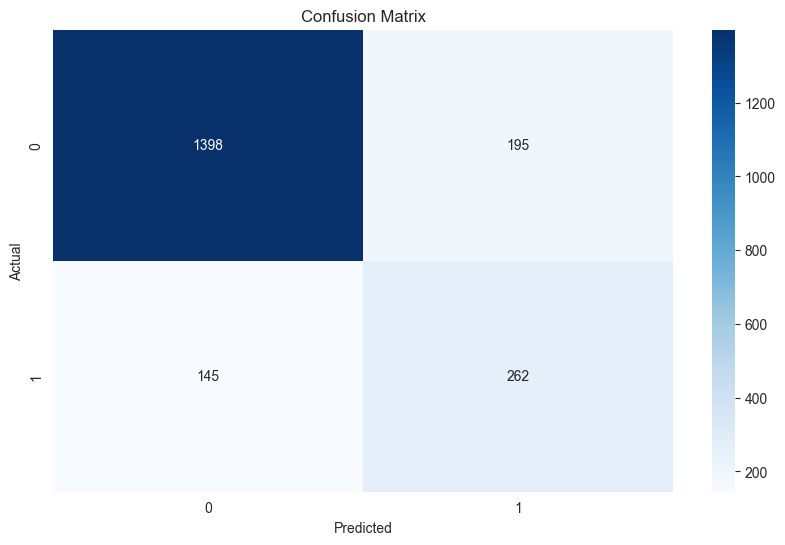

In [21]:
print('Model training in process...')
model_pipeline.fit(X_train, y_train)

# Predicting outcomes
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Printing metrics
print('\nClassification Report')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix')
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluating Real-World Business Consequences

In [22]:
# Calculating business impact of churn
# Let's assume that the retention cost is $250 and the churn cost is $5000
# So it costs 5% of the churn to try and retain a customer

tn, fp, fn, tp = conf_matrix.ravel()

# Churn Cost if we take no action to prevent customer loss
cost_do_nothing = (fn + tp) * 5000

# Adding up the Retention Cost + Missed Opportunities + Churn Cost
cost_model = (fp * 250) + (tp * 250) + (fn * 5000)

savings = cost_do_nothing - cost_model

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $839,250
Savings: $1,195,750


In [24]:

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $839,250
Savings: $1,195,750


# Compaing Alternative Models

Model training in process...
Model LogisticRegression completed. | AUC: 0.7519
Model RandomForest completed. | AUC: 0.8308
Model SVM completed. | AUC: 0.8312
Model XGBoost completed. | AUC: 0.8288


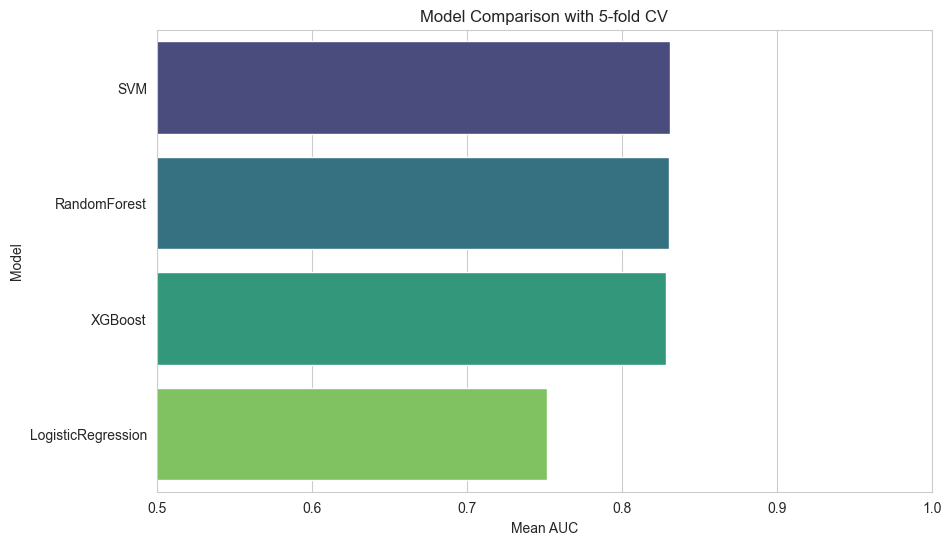

In [26]:
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "LogisticRegression": LogisticRegression(solver = 'liblinear', random_state = RANDOM_SEED),
    "RandomForest": RandomForestClassifier(n_estimators = 100, random_state = RANDOM_SEED),
    "SVM": SVC(probability = True, random_state = RANDOM_SEED),
    "XGBoost": XGBClassifier(n_estimators = 100, eval_metric = 'logloss', random_state = RANDOM_SEED)
}

results = []

print('Model training in process...')

for name, model in models.items():
    # Creating pipeline
    current_pipeline = clone(model_pipeline)
    current_pipeline.steps.pop(-1)
    current_pipeline.steps.append(('classifier', model))

    # Including cross-validation with 5 folds
    # Optimizing for ROC-AUC to measure model ability to distinguish classes
    cv_scores = cross_val_score(
        current_pipeline,
        X_train,
        y_train,
        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED),
        scoring = 'roc_auc',
        n_jobs = -1
    )

    # Logging results
    results.append({
        'Model': name,
        'Mean AUC': cv_scores.mean(),
        'Standard Deviation': cv_scores.std()
    })

    print(f'Model {name} completed. | AUC: {cv_scores.mean():.4f}')

# Creating dataframe with results
results_df = pd.DataFrame(results).sort_values(by = 'Mean AUC', ascending = False)

# Showing comparison of results
sns.barplot(data = results_df, x = 'Mean AUC', y = 'Model', palette = 'viridis')
plt.title('Model Comparison with 5-fold CV')
plt.xlim(0.5, 1)
plt.show()

## Comments

Very amusing to see SVM in the lead! The model would not be scalable since it's $O(n^3)$, but it's a fun exercise anyways.

We can go ahead and tune the XGBoost model to see if we can crack an ROC-AUC of 0.90.

# Tuning Hyperparameters with Bayesian Optimization

In [29]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

print('Starting Bayesian Optimization for XGBoost...')

# Defining the search space
search_spaces = {
    'classifier__n_estimators': Integer(100, 500),
    'classifier__learning_rate': Real(0.01, 0.3, prior = 'log-uniform'),
    'classifier__max_depth': Integer(3, 15),
    'classifier__min_child_weight': Integer(1, 10),
    'classifier__gamma': Real(0, 0.5),
    'classifier__subsample': Real(0.6, 1.0),
    'classifier__colsample_bytree': Real(0.6, 1.0),
    'classifier__scale_pos_weight': Real(1, 10)
}

# Creating search object
opt = BayesSearchCV(
    estimator = model_pipeline,
    search_spaces = search_spaces,
    n_iter = 30,
    cv = 3,
    n_jobs = -1,
    random_state = RANDOM_SEED,
    scoring = 'roc_auc',
    verbose = 1
)

# Searching
opt.fit(X_train, y_train)

print(f'Best AUC Score: {opt.best_score_:.4f}')
print(f'Best Parameters found: {opt.best_params_}')

Starting Bayesian Optimization for XGBoost...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 

# Evaluating Final Models

Test AUC: 0.7588
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.56      0.65      0.60       407

    accuracy                           0.83      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.83      0.83      2000



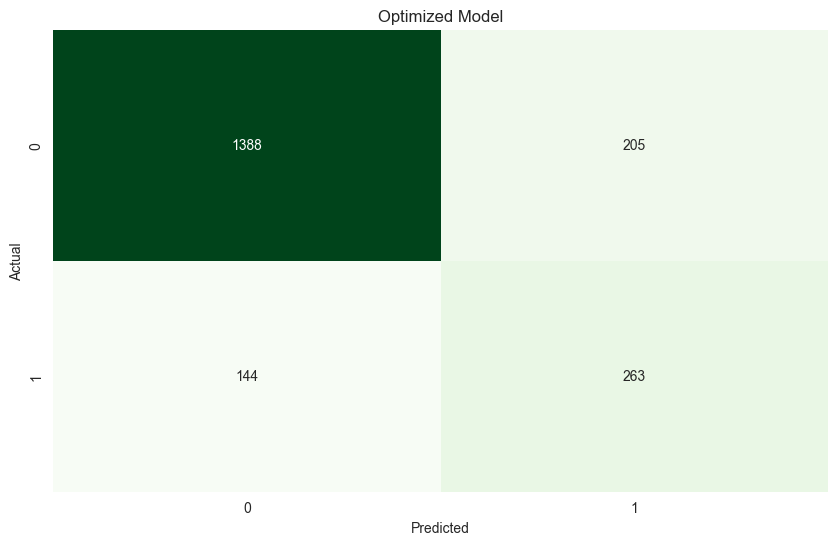

In [30]:
best_model = opt.best_estimator_

# Predicting on test data
y_pred_final = best_model.predict(X_test)
y_prob_final = best_model.predict_proba(X_test)[:, 1]

# Metrics
print(f'Test AUC: {roc_auc_score(y_test, y_pred_final):.4f}')
print(classification_report(y_test, y_pred_final))

# Confusion matrix
plt.figure(figsize = (10, 6))
matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', cbar = False)
plt.title('Optimized Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance

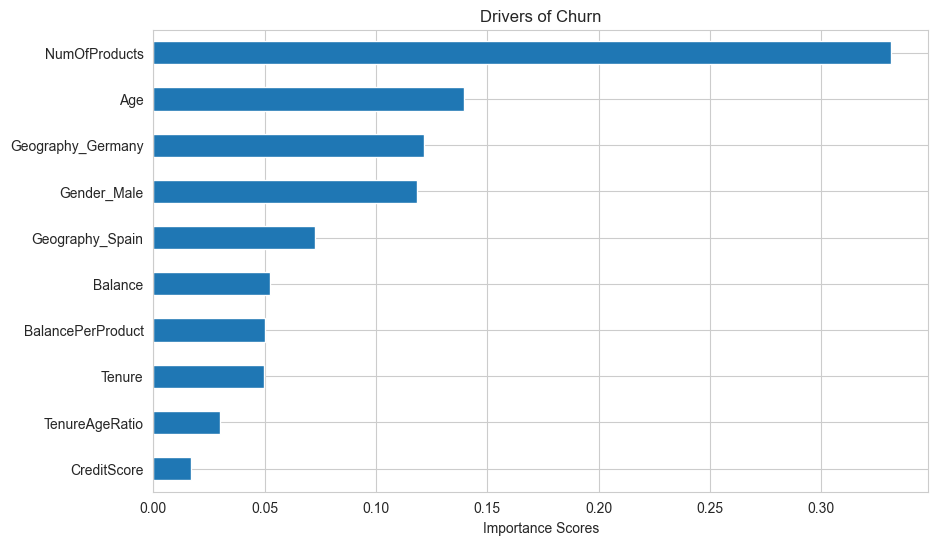

In [31]:
# Extracting feature names from One-Hot Encoder values
feature_names = (numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Extracting feature importances from XGBoost model
importances = best_model.named_steps['classifier'].feature_importances_

# Graph
plt.figure(figsize = (10, 6))
feat_importances = pd.Series(importances, index = feature_names)
feat_importances.nlargest(10).plot(kind = 'barh').invert_yaxis()
plt.title('Drivers of Churn')
plt.xlabel('Importance Scores')
plt.show()